# <center> Conditional logic with the QICK demonstration

In this demo you will send and receive a pulse in loopback conditional on the value of a number written to the QICK. A similar application of the QICK conditional logic can enable the active reset of qubits. 

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc


### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0


In [3]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        
        # Set threshold
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg["ro_ch"]],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
        self.label('LABEL')

        # control should wait until the readout is over
        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

### When the value of <code> number </code> is above the threshold, the conditional statement is False so you see a loopback pulse.

In [4]:
config={"res_ch":6, # --Fixed
        "ro_ch":0, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":1000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100,
        ### New variables
        "number": 100,
        "threshold": 50
       }

prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc, progress=True)

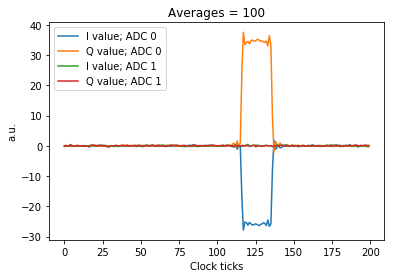

In [5]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Conditional_False_Pulse.pdf", dpi=350)

### When the value of <code> number </code> is below the threshold, the conditional statement is True so you don't see a loopback pulse.

In [6]:
config["number"]=10

prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc, progress=True)

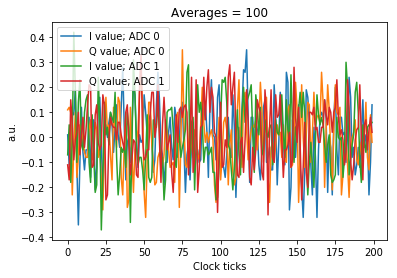

In [7]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Conditional_True_NoPulse.pdf", dpi=350)